In [541]:
###Packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
from IPython.display import Image
from IPython.core.display import HTML
import datetime
import math
import scipy.optimize as optimize
import statistics
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from scipy import stats
import scipy
import warnings
from scipy.stats import norm
from sklearn import datasets, linear_model
from sklearn.model_selection import train_test_split, KFold
from sklearn import ensemble
from sklearn import datasets
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import KFold 
warnings.filterwarnings('ignore')
plt.style.use('ggplot')
from IPython.display import Image
from IPython.core.display import HTML 

In [327]:
### data loading 
df = pd.read_csv('./data/loan.csv', low_memory=False)

In [307]:
### data loading & cleaning
df = pd.read_csv('./data/loan.csv', low_memory=False)
df = df.drop_duplicates(subset='id').reset_index(drop=True)
df.replace([np.inf, -np.inf], np.nan)
df = df.dropna(subset=['id', 'funded_amnt','int_rate','installment','grade'])
df = df[np.isfinite(df['annual_inc']) & np.isfinite(df['int_rate']) &  np.isfinite(df['funded_amnt'])].copy()

In [308]:
###changing data type to appropriate date type 
df['last_pymnt_d']=pd.to_datetime(df.last_pymnt_d)
df['issue_d']=pd.to_datetime(df.issue_d)

In [309]:
###fill missing last_payments(no payments) with issue date, may want a separete column for this treatment
###This is for calculation of IRRs later
df['last_pymnt_d'].fillna(df.issue_d,inplace=True)

In [310]:
###Some pre-processing for ease of calculations
df['issue_yr'] = df.issue_d.dt.year
df['issue_mo']= df.issue_d.dt.month
df['last_pymnt_yr'] = df.last_pymnt_d.dt.year
df['last_pymnt_mo']= df.last_pymnt_d.dt.month
df['mo_diff'] = pd.to_numeric((df['last_pymnt_yr'] - 
                          df['issue_yr'])*12 + df['last_pymnt_mo'] -df['issue_mo'])

In [311]:
###Flag for completed loans
searchfor = ['Fully Paid', 'Charged Off', 'Default']
defaults = ['Charged Off', 'Default']
df['loan_completion_flag']=  np.where(df['loan_status'].str.contains('|'.join(searchfor)) ,1, np.nan)
###Flag for fully paid loans
df['fully_paid'] = np.where(df['loan_status'].str.contains('Fully Paid') ,1, 
                                  np.where(df['loan_status'].str.contains('|'.join(defaults)) ,0,np.nan))


In [312]:
###Average payment = Total payment - recoveries - last payment amount over the life -1 month of the investment
df['avg_pymnt'] = (df['total_pymnt']-df['recoveries']-df['last_pymnt_amnt'])/(np.maximum((df['mo_diff']-1),0))
###Treating infinites that appear when there is no payment or only 1 payment 
df['avg_pymnt'] = (df['avg_pymnt']).replace(np.Inf,0)
df['avg_pymnt'] = (df['avg_pymnt']).replace(-np.Inf,0)

In [313]:
###IRR calculations
###Input: a row of a dataframe with lending data 
def irr_calc(x):  
    ##varible initialization
    initial_invest = -x['funded_amnt']
    avg_payment = x['avg_pymnt']
    num_payments = np.max(int(x['mo_diff'])-1,0)
    recovery = x['recoveries'] -x['collection_recovery_fee']
    recovery_duration = np.maximum(36 - num_payments + 1 + 12,12)
    avg_recovery = recovery/recovery_duration
    last_payment_amount = x['last_pymnt_amnt']
    ###IRR calculation, input: series of cash flows, total payment - recoveries
    ###evenly divided and spread across the life of the loan and finally recovery and chargeoff fees
    return ((np.irr([initial_invest]+[avg_payment]*num_payments + [last_payment_amount] +
                    [avg_recovery]*recovery_duration)+1)**12-1)

In [314]:
###Calculating at a row level, individual security IRRs. Method will be faulty for loans that didn't mature.
###Warning: the calculation takes a fair amount of time ~few minutes
df['irr']=df.apply(irr_calc, axis=1)

In [315]:
##NaNs returned from IRRs with 0 payments should be -100% return 
df['irr']=df['irr'].replace(np.NaN,-1)

In [316]:
####Filter down to completed loans and has at least 36 months of possible history
df_filtered = df[df['loan_status'].str.contains('|'.join(searchfor))].query("term == ' 36 months' and issue_yr <=2012").copy()

In [317]:
##making grade flags
grade_flags = pd.get_dummies(df_filtered.grade) 
home_flag = pd.get_dummies(df_filtered.home_ownership) 
df_filtered=pd.concat([df_filtered,grade_flags,home_flag], axis=1)

# Model Testing

In [470]:
columns= ["int_rate","annual_inc","funded_amnt","F","G"]

In [471]:
kf = KFold(n_splits=10) # Define the split - into 2 folds 
kf.get_n_splits(df_filtered) # returns the number of splitting iterations in the cross-validator
print(kf) 

KFold(n_splits=10, random_state=None, shuffle=False)


In the last [post](http://jameslee.posthaven.com/peer-to-peer-lending-markets-part-1-using-simple-random-sampling-to-gain-insight-on-investment-returns), we looked at the how random sampling can give good insights on portfolio return distributions using the principles of Central Limit Theorem. We saw that an arbitrarily more number of loans would have improved the risk-adjusted returns by diversifying the default risk away. In this post, we will answer the question - given that we want to invest into some number of loans, how can we select these loans in a way that they will maximize our portfolio returns.

For this exercise, we will employ linear regression and gradient boosting regression. [Gradient boosting regression](https://medium.com/mlreview/gradient-boosting-from-scratch-1e317ae4587d) essentially builds a set of weak models that sequentially improves upon the errors of the previous models. Then, an ensemble of these models is used to make a prediction.

We will compare these two models using [k-fold cross validation](https://machinelearningmastery.com/k-fold-cross-validation/). Image below does a much better job than I can in explaining this method, but essentially, we split our data several times, and each split is further split into a validation set and a training set. We then build our model on a training set and measure its accruacy on a validation set and repeat this for each split we made. The outcome is a distribution of accuracy and performance metrics we can compare across different models.

In [558]:
Image(url= "https://cdn-images-1.medium.com/max/1080/1*4G__SV580CxFj78o9yUXuQ.png")

Credits to Josephn Nelson for the helpful image. 

Above approach can be implemented rather simply using many of the black box functions available in python. Below is my implementation. For each step, we make our models and predictions, then measure their accuracy. Additionally, we choose 100 loans that our model thinks will perform the best in terms of IRR, and then look at its actual returns in a validation set. We also collect 100 randomly selected loans from the same validation set as our control to compare our models against. Features for the model were selected using a nested model testing and F-statistics. More detailed code can be found in my GitHub [repo](https://github.com/yjs1210/lending-tree).

In [ ]:
kf = KFold(n_splits=10) # Define the split - into 10 folds 
kf.get_n_splits(df_filtered) # returns the number of splitting iterations in the cross-validator

In [ ]:
all_trials = []
for index, (train, test) in enumerate(kf.split(df_filtered)):
    x_train = df_filtered.iloc[train][columns]
    y_train = df_filtered.iloc[train]['irr']
    y_test = df_filtered.iloc[test]['irr']
    x_test = df_filtered.iloc[test][columns]
    ###GBM
    params = {'n_estimators': 500, 'max_depth': 4, 'min_samples_split': 2,
          'learning_rate': 0.01, 'loss': 'ls'}
    clf = ensemble.GradientBoostingRegressor(**params)
    clf.fit(x_train, y_train)
    gbm_predictions = clf.predict(x_test)
    gbm_mse = mean_squared_error(y_test, gbm_predictions)
    
    ##Linear Model
    lm = linear_model.LinearRegression()
    lm.fit(x_train, y_train)
    lm_predictions = lm.predict(x_test)
    lm_mse = mean_squared_error(y_test, lm_predictions)
    df_temp = pd.DataFrame({'irr':y_test, 'gbm_predictions':gbm_predictions, 'lm_predictions':lm_predictions})
    lm_returns = np.mean(df_temp.nlargest(100, 'gbm_predictions')['irr'])
    gbm_returns= np.mean(df_temp.nlargest(100, 'lm_predictions')['irr'])
    
    ##Random Sampling
    rs_returns = np.mean(y_test.sample(100,replace=False))

    all_trials.append({
        'index': index,
        'gbm_mse': gbm_mse,
        'gbm_returns': gbm_returns,
        'lm_mse': lm_mse,
        'lm_returns': lm_returns,
        'rs_returns': rs_returns
    })
    
output=pd.DataFrame.from_records(all_trials)

Below are the average accuracies(mean squared error) and returns over our 10 validation sets. It seems that linear regression won out on both metrics. 

In [556]:
print('gbm_returns:', np.mean(output['gbm_mse']),', linear regression accuracy:' ,np.mean(output['lm_mse']))

gbm_returns: 0.04659642356214374 , linear regression accuracy: 0.04608982579757738


In [557]:
print('gbm_returns:', np.mean(output['gbm_returns']),', linear regression returns:' ,np.mean(output['lm_returns']))

gbm_returns: 0.10226936194421943 , linear regression returns: 0.1084010800601943


Since we collected 10 trials across 10 validation sets, we can plot these accuracy and return measures. 

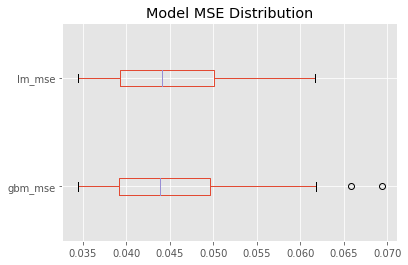

In [555]:
output[['gbm_mse', 'lm_mse']].boxplot(vert=False)
plt.title('Model MSE Distribution')
plt.show()

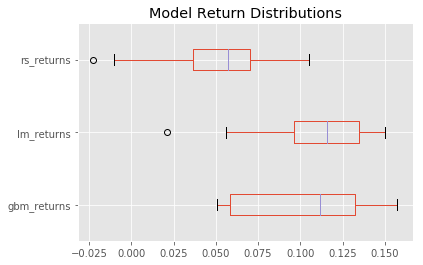

In [548]:
output[['gbm_returns', 'lm_returns','rs_returns']].boxplot(vert=False)
plt.title('Model Return Distributions')
plt.show()

Both of our models far outperformed the random sampling method, almost doubling the returns. This is a strong indication that our model can garner insights from the features to select loans that are less likely to default, and yield higher returns. Should you invest into a peer-to-peer lending market, I would advise using signals to try to get a better return rather than using one of the platform's proprietary automated investment strategy. One thing we must be cognizant of is that even though we applied cross validation to minimize bias, there may be some look ahead bias in our dataset in a sense that we are using complete information of the loans that would otherwise not be available at the time of investment. So further testing would be required by employing these models on new loans, and then observing its returns over its life time. However, that would be an unrealistic effort.

In terms of the models, Linear regression not only yields consistently better accuracies but also yields higher returns than the GBM method. However, we chose our features using nested model testing on linear regression models and then used the same features for the GBM method. In the next post, we will investigate hyperparameter tuning and feature selection to try to build a GBM model that can outperform the linear regression model.
